In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from operator import itemgetter

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

from torchbearer import Trial, VALIDATION_DATA, TEST_DATA

from tqdm import tqdm

In [57]:
human_nodes = pd.read_csv("data/BIOSTR_homo_sapiens.nodes", sep=" ")
human_map = dict(zip(human_nodes['nodeSymbol'], np.arange(len(human_nodes))))
human_map_rev = {v: k for k, v in human_map.items()}

In [3]:
### Loading dataset ###
#######################

n_samples = np.loadtxt('data/ML_data/n.txt')
n_pos = np.loadtxt('data/ML_data/n_pos.txt')
n1o_samples = np.loadtxt('data/ML_data/n1o.txt')
n1o_pos = np.loadtxt('data/ML_data/n1o_pos.txt')

if len(n_samples) == len(n1o_samples):
    print("Datasets loaded successfully")
    N = len(n_samples)
else:
    print("Error loading datasets, different sizes")

Datasets loaded successfully


In [5]:
main_proteins_positions = np.sort(np.unique(np.concatenate([n_pos, n1o_pos]))).astype(int)
N_red = len(main_proteins_positions)
print("Number of unique proteins:", N_red)
map_pos_prot = {i:j for i,j in enumerate(main_proteins_positions)}
map_prot_pos = {j:i for i,j in enumerate(main_proteins_positions)}
n_pos_reduced = np.array([[map_prot_pos[idx] for idx in n_pos[j]] for j in range(len(n_pos))])
n1o_pos_reduced = np.array([[map_prot_pos[idx] for idx in n1o_pos[j]] for j in range(len(n1o_pos))])

Number of unique proteins: 11060


In [ ]:
def randomize_top_entries_vectors(samples, positions, dim_vec=1000):
    randomized_samples = np.random.rand(samples.shape[0], dim_vec) * 0.1
    for i in range(len(samples)):
        for pos, samp in zip(positions[i], samples[i]):
            randomized_samples[i, pos.astype(int)] = samp
    return randomized_samples

In [7]:
n_randomized = randomize_top_entries_vectors(n_samples, n_pos_reduced, dim_vec=N_red)
n1o_randomized = randomize_top_entries_vectors(n1o_samples, n1o_pos_reduced, dim_vec=N_red)

In [8]:
# Training samples
print("Loading Train and Val")
X = np.concatenate([n_randomized, n1o_randomized], axis=0)

# Assigning label, 0 for only non-oncogenic layers, 1 for oncogenic layer presence
y = np.concatenate([[0]*N, [1]*N])

print(X.shape, y.shape)

Loading Train and Val
(6000, 11060) (6000,)


In [ ]:
class OncoVirusDataset(Dataset):
    
    def __init__(self, X, y=None, test=False):
        self.test = test
        self.data = X
        self.labels = y

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        dat = self.data[idx]#np.array([self.data[idx].nonzero()[0], self.data[idx][self.data[idx].nonzero()[0]]])
        if self.test:
            return torch.from_numpy(dat).type(torch.FloatTensor)
        else:
            return [torch.from_numpy(dat).type(torch.FloatTensor), int(self.labels[idx])]
        

In [10]:
class Model(nn.Module):
    def __init__(self, input_dim=19945):
        super().__init__()
        self.linear = nn.Linear(in_features=input_dim, out_features=2)

    def forward(self, x):
        x=self.linear(x)
        return x

model = Model()

In [11]:
def set_up_trial(X, y, val_size=0.2, test_size=0.2, n_epochs=600, model_input_dim=19945):
    index_rem = np.random.choice(len(X), size=int(len(X)*test_size), replace=False)
    X_test = X[index_rem]
    y_test = y[index_rem]
    X_train, X_val, y_train, y_val = train_test_split(X[np.delete(np.arange(len(X)), index_rem)], y[np.delete(np.arange(len(X)), index_rem)], test_size=val_size, random_state=42)

    mydat_train = OncoVirusDataset(X_train, y_train)
    mydat_val = OncoVirusDataset(X_val, y_val)
    mydat_test = OncoVirusDataset(X_test, y_test)

    train_dataloader = DataLoader(mydat_train, batch_size=20, shuffle=True, num_workers=0)
    val_dataloader = DataLoader(mydat_val, batch_size=20, shuffle=False, num_workers=0)
    test_dataloader = DataLoader(mydat_test, batch_size=20, shuffle=False, num_workers=0)

    model = Model(input_dim=model_input_dim)
    
    trial = Trial(model,
                  optim.Adam(model.parameters(), lr=1e-3),
                  nn.CrossEntropyLoss(), 
                  metrics=["loss", "acc"])
    
    trial.with_generators(train_generator=train_dataloader, 
                              val_generator=val_dataloader, 
                              test_generator=test_dataloader)

    my_trial = trial.run(epochs=n_epochs, verbose=1)

    return trial, my_trial

In [20]:
trial, mytrial = set_up_trial(X, y, val_size=0.2, test_size=0.1, n_epochs=100, model_input_dim=N_red)

  0%|          | 0/100 [00:00<?, ?it/s]

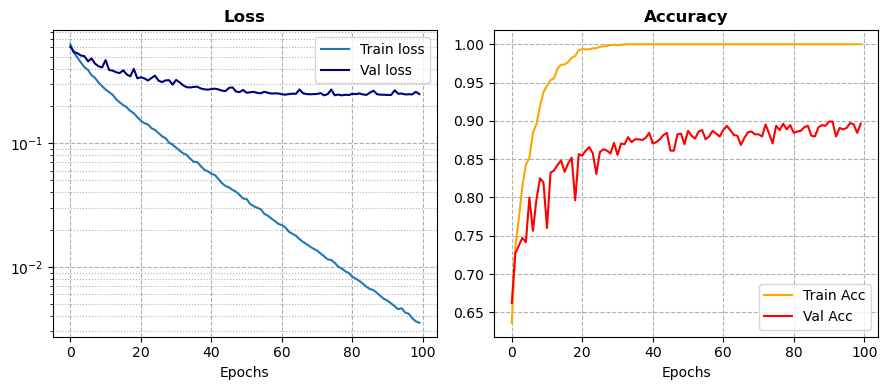

In [22]:
### Plot loss and accuracy ###
##############################

_, ax = plt.subplots(1,2,figsize=(9,4))

ax[0].semilogy([mt["loss"] for mt in mytrial], label="Train loss", color="C0")
ax[0].semilogy([mt["val_loss"] for mt in mytrial], label="Val loss", color="navy")
ax[0].set_title("Loss", fontweight="bold")

ax[1].plot([mt["acc"] for mt in mytrial], label="Train Acc", color="orange")
ax[1].plot([mt["val_acc"] for mt in mytrial], label="Val Acc", color="red")
ax[1].set_title("Accuracy", fontweight="bold")

[axi.set_xlabel("Epochs") for axi in ax]
[axi.legend() for axi in ax]
[axi.grid(ls="--") for axi in ax]
ax[0].grid(which="minor", ls=":")
plt.tight_layout()

In [16]:
def plot_confusion_matrix(trial, which="val"):
    if which=="val":
        val_pred=np.argmax(trial.predict(data_key=VALIDATION_DATA).detach().numpy(),axis=1)
        val_true=[v[1] for v in trial.state.data["validation_generator"].dataset]
        title="VALIDATION CONFUSION MATRIX"
    elif which=="test":
        val_pred=np.argmax(trial.predict(data_key=TEST_DATA).detach().numpy(),axis=1)
        val_true=[v[1] for v in trial.state.data["test_generator"].dataset]
        title="TEST CONFUSION MATRIX"
    else:
        raise ValueError("which should be either val or test")
    
    confM_val = confusion_matrix(y_true = val_true, y_pred = val_pred, labels=np.arange(2))

    plt.figure(figsize=(6,6))
    sns.heatmap(confM_val, annot=True, fmt="g", cbar=False, cmap="magma")
    plt.title(title, weight="bold")
    plt.ylabel("True labels")
    plt.xlabel("Predicted labels")
    plt.tight_layout()
    
    return confM_val

0/1(p):   0%|          | 0/54 [00:00<?, ?it/s]

/home/francesco/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: State was accessed with a string: validation_generator, generate keys with StateKey(str).
  after removing the cwd from sys.path.


array([[502,  57],
       [ 55, 466]])

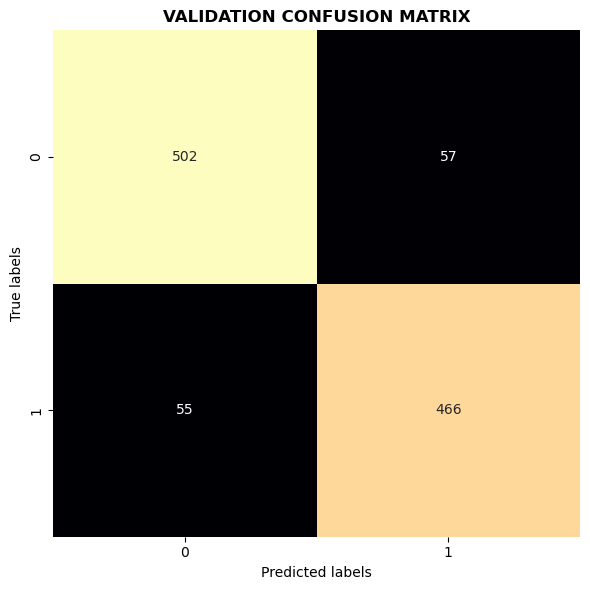

In [23]:
plot_confusion_matrix(trial, which="val")

/home/francesco/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: State was accessed with a string: model, generate keys with StateKey(str).
  


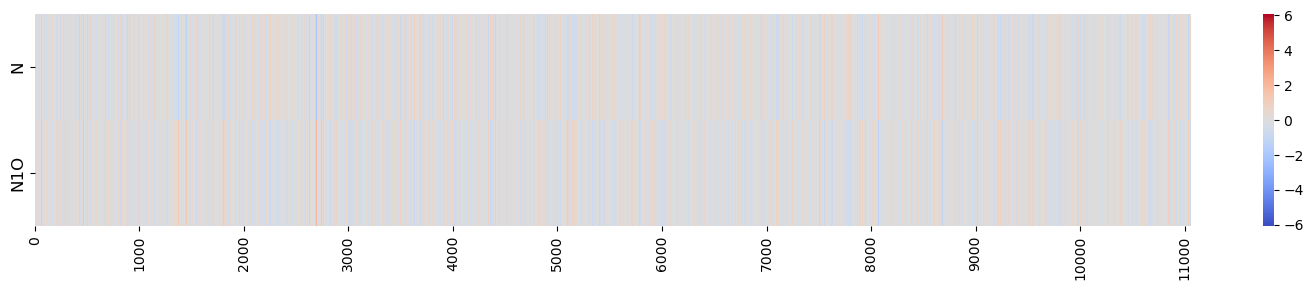

In [30]:
plt.figure(figsize=(15,3))
weights = trial.state['model'].linear.weight.detach().numpy()
sns.heatmap(weights, cmap="coolwarm", yticklabels=["N","N1O"])
plt.yticks(fontsize=12)
plt.xticks(ticks=np.arange(0,N_red,1000), labels=np.arange(0,N_red,1000))
plt.tight_layout()
plt.show()

In [45]:
weights_diff = np.abs(weights[1] - weights[0])
N_top_prots = 50
top_class_prots = np.argsort(weights_diff)[-N_top_prots:][::-1]

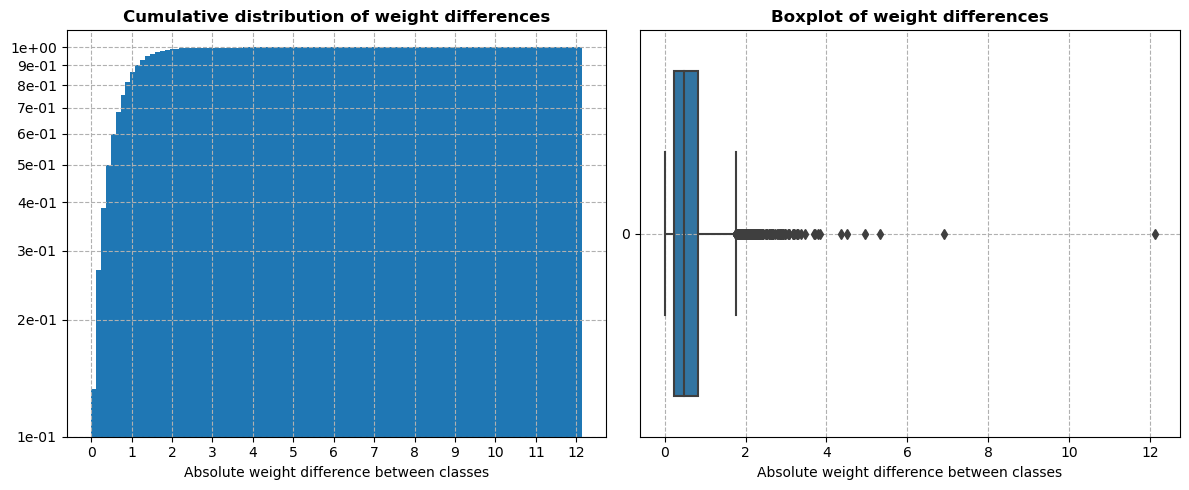

In [85]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(weights_diff, bins=100, cumulative=True, density=True)
plt.title("Cumulative distribution of weight differences", fontweight="bold")
plt.xlabel("Absolute weight difference between classes")
plt.xticks(ticks=np.arange(0, np.max(weights_diff)+0.1, 1))
plt.yscale("log")
plt.yticks(ticks=np.arange(0.1,1.1,0.1), labels=[f"{tick:.0e}" for tick in np.arange(0.1,1.1,0.1)])
plt.grid(ls="--")

plt.subplot(1,2,2)
sns.boxplot(weights_diff, orient="h")
plt.title("Boxplot of weight differences", fontweight="bold")
plt.xlabel("Absolute weight difference between classes")
plt.grid(ls="--")

plt.tight_layout()

In [ ]:
itemgetter(*itemgetter(*top_class_prots)(map_pos_prot))(human_map_rev)

('HIPK2',
 'CDH1',
 'CREB1',
 'HIST1H3A',
 'CTBP1',
 'CTNNA1',
 'SKI',
 'UBE2I',
 'SRPK1',
 'BAG3',
 'TP73',
 'CTNND1',
 'CALR',
 'EGFR',
 'SUMO2',
 'EIF4E',
 'CD4',
 'DAXX',
 'HIST2H2BE',
 'LMNA',
 'AXIN1',
 'SUMO1',
 'PRMT1',
 'MAP3K1',
 'ALDOA',
 'PML',
 'NOTCH1',
 'ANKRD17',
 'NANOG',
 'EZR',
 'MPP2',
 'MED4',
 'TNFSF11',
 'DCPS',
 'HSP90AA1',
 'SIRT1',
 'ATM',
 'CHD5',
 'RTP4',
 'XPO1',
 'STAU1',
 'REEP5',
 'CHEK2',
 'RC3H2',
 'ZFP28',
 'CDC42SE1',
 'UPF1',
 'SPATA17',
 'SP100',
 'MDM4')